In [2]:
import sys

sys.path.append('../src')

from swfilter import SlicedWassersteinFilter

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from scipy.io import arff
import mlflow
import seaborn as sns


First, run this from terminal :

mlflow server --host 127.0.0.1 --port 8081

In [8]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# Create a new MLflow Experiment
experiment_id = "swfilter_exp_precision"
experiment = mlflow.set_experiment(experiment_id)

# Get Experiment Details
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Name: {}".format(experiment.name))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

2024/08/04 12:45:29 INFO mlflow.tracking.fluent: Experiment with name 'swfilter_exp_precision' does not exist. Creating a new experiment.


Experiment_id: 269544680693021678
Artifact Location: mlflow-artifacts:/269544680693021678
Name: swfilter_exp_precision
Tags: {}
Lifecycle_stage: active


In [9]:
dataset_list = [['Arrhythmia', 'Arrhythmia_withoutdupl_norm_46'],
                ['Pima', 'Pima_withoutdupl_norm_35'],
                ['WPBC','WPBC_withoutdupl_norm'],
                ['Shuttle', 'Shuttle_withoutdupl_norm_v01'],
                ['Glass', 'Glass_withoutdupl_norm'],
                ['Ionosphere','Ionosphere_withoutdupl_norm'],
                ['Lymphography','Lymphography_withoutdupl_norm_idf'],
                #['Cardiotocography','Cardiotocography_withoutdupl_norm_22']
                ]

In [10]:
def import_dataset(folder_name:str, dataset_name:str)->pd.DataFrame:
    arff_file = arff.loadarff(f'../datasets/{folder_name}/{dataset_name}.arff')
    df_file = pd.DataFrame(arff_file[0])
    features = df_file.drop(columns=['outlier', 'id'])
    label = df_file['outlier']
    return features, label, df_file

def generate_data(folder_name:str, dataset_name:str, test_size:float=0.5, seed:int=42):
    features, label, df_file = import_dataset(folder_name, dataset_name)
    X = np.array(features.values)
    y = np.array(label.values == b'yes')
    y= np.where(y, -1, 1)

    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, y, test_size=test_size, random_state=seed)
    data = {'X_train':X_train, 'X_test':X_test, 'Y_train':Y_train, 'Y_test':Y_test, 'X':X, 'y':y}
    return data

    

## hyperopt

In [12]:
from hyperopt import hp, fmin, tpe, anneal, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, make_scorer
from functools import partial
import mlflow


# Adjusting the objective functions to include cross-validation on training data and evaluation on testing data

def objective_lof(space, X_train, Y_train, X_test, Y_test, experiment_id, dataset_name):
    mlflow.set_experiment(experiment_id)
    with mlflow.start_run():
        n_neighbors = int(space['n_neighbors'])
        algorithm = space['algorithm']
        leaf_size = int(space['leaf_size'])
        metric = space['metric']
        
        model = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            algorithm=algorithm,
            leaf_size=leaf_size,
            metric=metric,
            novelty=False
        )
        
        # Cross-validation on training data
        #cv_score = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring).mean()
    

        # Fit the model on the entire training dataset
        Y_pred = model.fit_predict(X_train)
        train_precision = sk.metrics.precision_score(Y_train, Y_pred, zero_division=0)
        train_accuracy = sk.metrics.accuracy_score(Y_train, Y_pred)

        
        # Evaluate on the testing data
        Y_pred = model.fit_predict(X_test)
        test_accuracy = sk.metrics.accuracy_score(Y_test, Y_pred)
        test_precision = sk.metrics.precision_score(Y_test, Y_pred, zero_division=0)
        test_recall_score = sk.metrics.recall_score(Y_test, Y_pred, zero_division=0)
        
        true_positive = np.sum((Y_test == -1) & (Y_pred == -1))
        false_positive = np.sum((Y_test == 1) & (Y_pred == -1))
        true_negative = np.sum((Y_test == 1) & (Y_pred == 1))
        false_negative = np.sum((Y_test == -1) & (Y_pred == 1))
        mlflow.log_metric("true_positive", true_positive)
        mlflow.log_metric("false_positive", false_positive)
        mlflow.log_metric("true_negative", true_negative)
        mlflow.log_metric("false_negative", false_negative)
        
        # Log parameters, cross-validation score, and testing score
        mlflow.log_param("n_neighbors", n_neighbors)
        mlflow.log_param("algorithm", algorithm)
        mlflow.log_param("leaf_size", leaf_size)
        mlflow.log_param("metric", metric)
        mlflow.log_param("dataset_name", dataset_name)
        mlflow.log_metric("train_precision", train_precision)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("test_recall_score", test_recall_score)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.set_tag("model", "LocalOutlierFactor")
        
        return {'loss': -train_precision, 'status': STATUS_OK}

def objective_forest(space, X_train, Y_train, X_test, Y_test, experiment_id, dataset_name):
    mlflow.set_experiment(experiment_id)
    with mlflow.start_run():
        n_estimators = int(space['n_estimators'])
        max_samples = int(space['max_samples'])
        contamination = space['contamination']
        max_features = int(space['max_features'])
        
        model = IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            max_features=max_features,
            random_state=42
        )
        
        # Cross-validation on training data
        #cv_score = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring).mean()
        # Fit the model on the entire training dataset
        Y_pred = model.fit_predict(X_train)
        train_precision = sk.metrics.precision_score(Y_train, Y_pred, zero_division=0)
        train_accuracy = sk.metrics.accuracy_score(Y_train, Y_pred)

        
        # Evaluate on the testing data
        Y_pred = model.fit_predict(X_test)
        test_accuracy = sk.metrics.accuracy_score(Y_test, Y_pred)
        test_precision = sk.metrics.precision_score(Y_test, Y_pred, zero_division=0)
        test_recall_score = sk.metrics.recall_score(Y_test, Y_pred, zero_division=0)
        
        true_positive = np.sum((Y_test == -1) & (Y_pred == -1))
        false_positive = np.sum((Y_test == 1) & (Y_pred == -1))
        true_negative = np.sum((Y_test == 1) & (Y_pred == 1))
        false_negative = np.sum((Y_test == -1) & (Y_pred == 1))
        mlflow.log_metric("true_positive", true_positive)
        mlflow.log_metric("false_positive", false_positive)
        mlflow.log_metric("true_negative", true_negative)
        mlflow.log_metric("false_negative", false_negative)
        
        # Log parameters, cross-validation score, and testing score
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_samples", max_samples)
        mlflow.log_param("contamination", contamination)
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("dataset_name", dataset_name)
        mlflow.log_metric("train_precision", train_precision)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_recall_score", test_recall_score)
        mlflow.set_tag("model", "IsolationForest")
        
        return {'loss': -train_precision, 'status': STATUS_OK}
    

def objective_sw(space, X_train, Y_train, X_test, Y_test, experiment_id, dataset_name):
    mlflow.set_experiment(experiment_id)
    with mlflow.start_run():
        eps = float(space['eps'])
        n = int(space['n'])
        n_projections = int(space['n_projections'])
        p = float(space['p'])
        
        
        model = SlicedWassersteinFilter(
            eps=eps,
            n=n,
            n_projections=n_projections,
            p=p,
            seed=42,
            n_jobs=-1,
            swtype='original'  # Assuming a seed parameter is available for reproducibility
        )
        
        # Fit the model on the entire training dataset
        Y_pred = model.fit_predict(X_train)
        train_accuracy = sk.metrics.accuracy_score(Y_train, Y_pred)
        train_precision = sk.metrics.precision_score(Y_train, Y_pred, zero_division=0)
        

        # Fit the model on the entire training dataset
        Y_pred = model.fit_predict(X_test)
        test_precision = sk.metrics.precision_score(Y_test, Y_pred, zero_division=0)
        test_accuracy = sk.metrics.accuracy_score(Y_test, Y_pred)
        test_recall_score = sk.metrics.recall_score(Y_test, Y_pred, zero_division=0)
        
        true_positive = np.sum((Y_test == -1) & (Y_pred == -1))
        false_positive = np.sum((Y_test == 1) & (Y_pred == -1))
        true_negative = np.sum((Y_test == 1) & (Y_pred == 1))
        false_negative = np.sum((Y_test == -1) & (Y_pred == 1))
        mlflow.log_metric("true_positive", true_positive)
        mlflow.log_metric("false_positive", false_positive)
        mlflow.log_metric("true_negative", true_negative)
        mlflow.log_metric("false_negative", false_negative)

        
        # Log parameters, cross-validation score, and testing score
        mlflow.log_param("eps", eps)
        mlflow.log_param("n", n)
        mlflow.log_param("n_projections", n_projections)
        mlflow.log_param("p", p)
        mlflow.log_param("dataset_name", dataset_name)
        mlflow.log_metric("train_precision", train_precision)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_recall_score", test_recall_score)
        mlflow.set_tag("model", "SlicedWassersteinFilter")
        
        return {'loss': -train_precision, 'status': STATUS_OK}



In [13]:
lof_bool = True
forest_bool = True
sw_bool = True

#scoring = make_scorer(precision_score, zero_division=0)
max_evals = 150

In [14]:
for dataset in dataset_list:
    
    dataset_name = dataset[0]
    data = generate_data(dataset[0], dataset[1], test_size=0.5, seed=42)
    X_train = data['X_train']
    X_test = data['X_test']
    Y_train = data['Y_train']
    Y_test = data['Y_test']
    X = data['X']
    y = data['y']
    # Define search spaces
    space_lof = {
        'n_neighbors': hp.quniform('n_neighbors', 10, 100,1),
        'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': hp.quniform('leaf_size', 5, 100, 1),
        'metric': hp.choice('metric', ['euclidean', 'manhattan', 'chebyshev', 'minkowski'])
    }

    space_forest = {
        'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
        'max_samples': hp.quniform('max_samples', 1, X_train.shape[0],1),
        'contamination': hp.loguniform('contamination', -7, -0.7),
        'max_features': hp.quniform('max_features', 1, X_train.shape[1], 1)
    }

    space_sw = {
        'eps': hp.loguniform('eps', -7, 4),
        'n': hp.quniform('n', 10, 100, 1),
        'n_projections': hp.quniform('n_projections', 50, 200, 1),
        'p': hp.uniform('p', 0.6, 1)
    }

    if lof_bool:
        # Example of running a trial for LOF with the partial function
        objective_lof_partial = partial(objective_lof, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, experiment_id=experiment_id, dataset_name=dataset_name)

        trials_lof = Trials()
        best_lof = fmin(fn=objective_lof_partial,
                        space=space_lof,
                        algo=anneal.suggest,
                        max_evals=max_evals,
                        trials=trials_lof)

    if forest_bool:
        objective_forest_partial = partial(objective_forest, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test, experiment_id=experiment_id, dataset_name=dataset_name)

        trials_iforest = Trials()
        best_iforest = fmin(fn=objective_forest_partial,
                            space=space_forest,
                            algo=anneal.suggest,
                            max_evals=max_evals,
                            trials=trials_iforest)

    if sw_bool:
        objective_sw_partial = partial(objective_sw, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test,  experiment_id=experiment_id, dataset_name=dataset_name)

        # Example of running a trial for SlicedWassersteinFilter with the partial function
        trials_sw = Trials()
        best_sw = fmin(fn=objective_sw_partial,
                    space=space_sw,
                    algo=anneal.suggest,
                    max_evals=max_evals,
                    trials=trials_sw)

  0%|          | 0/150 [00:00<?, ?trial/s, best loss=?]

/home/julien/.local/lib/python3.10/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (91) is greater than the total number of samples (74). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(

/home/julien/.local/lib/python3.10/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (91) is greater than the total number of samples (74). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(



  4%|▍         | 6/150 [00:02<00:48,  2.98trial/s, best loss: -0.9857142857142858]

/home/julien/.local/lib/python3.10/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (79) is greater than the total number of samples (74). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(

/home/julien/.local/lib/python3.10/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (79) is greater than the total number of samples (74). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(



100%|██████████| 150/150 [01:30<00:00,  1.66trial/s, best loss: -1.0]              


## Extract results

In [15]:
df = mlflow.search_runs([experiment.experiment_id],filter_string="status = 'FINISHED'")
#building_ids = df['params.building_id']
display(df)
datasets = df['params.dataset_name'].unique()
print(datasets)
models = ['SlicedWassersteinFilter', 'IsolationForest', 'LocalOutlierFactor']

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_precision,metrics.test_precision,metrics.test_accuracy,metrics.true_negative,...,params.n_estimators,params.metric,params.leaf_size,params.algorithm,params.n_neighbors,tags.mlflow.source.name,tags.model,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.runName
0,77dd9661b52e49dfb218dd3d82ad4732,269544680693021678,FINISHED,mlflow-artifacts:/269544680693021678/77dd9661b...,2024-08-04 19:48:45.824000+00:00,2024-08-04 19:48:46.304000+00:00,0.972222,1.000000,1.000000,72.0,...,None,None,None,None,None,/home/julien/.local/lib/python3.10/site-packag...,SlicedWassersteinFilter,LOCAL,julien,dapper-finch-749
1,42b5670d861c45a3aa6af90eb0996e92,269544680693021678,FINISHED,mlflow-artifacts:/269544680693021678/42b5670d8...,2024-08-04 19:48:45.208000+00:00,2024-08-04 19:48:45.767000+00:00,1.000000,1.000000,0.702703,50.0,...,None,None,None,None,None,/home/julien/.local/lib/python3.10/site-packag...,SlicedWassersteinFilter,LOCAL,julien,incongruous-fly-29
2,216d3337e4674151bbd98a7f0b714dc9,269544680693021678,FINISHED,mlflow-artifacts:/269544680693021678/216d3337e...,2024-08-04 19:48:44.640000+00:00,2024-08-04 19:48:45.151000+00:00,0.000000,1.000000,0.243243,16.0,...,None,None,None,None,None,/home/julien/.local/lib/python3.10/site-packag...,SlicedWassersteinFilter,LOCAL,julien,mercurial-dove-559
3,69f91fd2b78e4da88e5c779d691fcb69,269544680693021678,FINISHED,mlflow-artifacts:/269544680693021678/69f91fd2b...,2024-08-04 19:48:44.139000+00:00,2024-08-04 19:48:44.583000+00:00,0.985507,1.000000,1.000000,72.0,...,None,None,None,None,None,/home/julien/.local/lib/python3.10/site-packag...,SlicedWassersteinFilter,LOCAL,julien,stately-shad-955
4,67f48d8c370241f395275545a47deb68,269544680693021678,FINISHED,mlflow-artifacts:/269544680693021678/67f48d8c3...,2024-08-04 19:48:43.628000+00:00,2024-08-04 19:48:44.081000+00:00,1.000000,1.000000,1.000000,72.0,...,None,None,None,None,None,/home/julien/.local/lib/python3.10/site-packag...,SlicedWassersteinFilter,LOCAL,julien,gifted-koi-824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,6d7a00f8802940979b17747ceff4520b,269544680693021678,FINISHED,mlflow-artifacts:/269544680693021678/6d7a00f88...,2024-08-04 16:46:09.793000+00:00,2024-08-04 16:46:10.055000+00:00,0.630000,0.573604,0.608889,113.0,...,None,euclidean,35,ball_tree,38,/home/julien/.local/lib/python3.10/site-packag...,LocalOutlierFactor,LOCAL,julien,hilarious-fawn-581
3146,92e99d42cc374518aca7c254cdffe425,269544680693021678,FINISHED,mlflow-artifacts:/269544680693021678/92e99d42c...,2024-08-04 16:46:09.472000+00:00,2024-08-04 16:46:09.738000+00:00,0.599057,0.568627,0.604444,116.0,...,None,manhattan,33,ball_tree,92,/home/julien/.local/lib/python3.10/site-packag...,LocalOutlierFactor,LOCAL,julien,puzzled-asp-176
3147,527be3ac3fe245cc9454b668660b8e62,269544680693021678,FINISHED,mlflow-artifacts:/269544680693021678/527be3ac3...,2024-08-04 16:46:09.148000+00:00,2024-08-04 16:46:09.418000+00:00,0.630000,0.573604,0.608889,113.0,...,None,minkowski,38,auto,36,/home/julien/.local/lib/python3.10/site-packag...,LocalOutlierFactor,LOCAL,julien,flawless-rat-295
3148,cde74f03e80c4834b31520dc327cd738,269544680693021678,FINISHED,mlflow-artifacts:/269544680693021678/cde74f03e...,2024-08-04 16:46:08.816000+00:00,2024-08-04 16:46:09.092000+00:00,0.599057,0.567961,0.604444,117.0,...,None,euclidean,42,ball_tree,82,/home/julien/.local/lib/python3.10/site-packag...,LocalOutlierFactor,LOCAL,julien,rumbling-worm-26


['Lymphography' 'Ionosphere' 'Glass' 'Shuttle' 'WPBC' 'Pima' 'Arrhythmia']


In [20]:
import json
result_dict = {}

for dataset in datasets:
    for model in models:
        best_val= df.loc[(df['params.dataset_name'] == dataset) & (df['tags.model'] == model)].sort_values(by=['metrics.train_precision', 'end_time'], ascending=True).tail(1)

        #best_mse = df.loc[(df['params.benchmark_functions'] == function) & (df['tags.model_name'] == model)].sort_values(by='metrics.MSE_val', ascending=True).head(1)
        #best_build = df.loc[ (df['tags.model_name'] == model)].sort_values(by='metrics.MAE_VAL_all_buildings_scaled', ascending=True).head(1)

        if f'{dataset}' not in result_dict.keys():
            result_dict[f'{dataset}'] = {}

       
        result_dict[f'{dataset}'][f'{model}'] = {'test_accuracy': best_val['metrics.test_accuracy'].values[0], 'test_precision' : best_val['metrics.test_precision'].values[0]}



In [21]:
df_2 = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in result_dict.items()
    }, 
    axis=0)

In [22]:



data_precision = pd.DataFrame(columns=datasets, index=models)
data_accuracy = pd.DataFrame(columns=datasets, index=models)

for ids in datasets:
        for model in models:
                if ids in df_2['test_precision'] and model and ids is not None:
                        data_accuracy[ids][model] = df_2['test_accuracy'][ids][model]
                        data_precision[ids][model] = df_2['test_precision'][ids][model]
                

                


/tmp/ipykernel_6916/3895824515.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_accuracy[ids][model] = df_2['test_accuracy'][ids][model]
/tmp/ipykernel_6916/3895824515.py:8: FutureWarning: ChainedAssignmentError: behaviour will chang

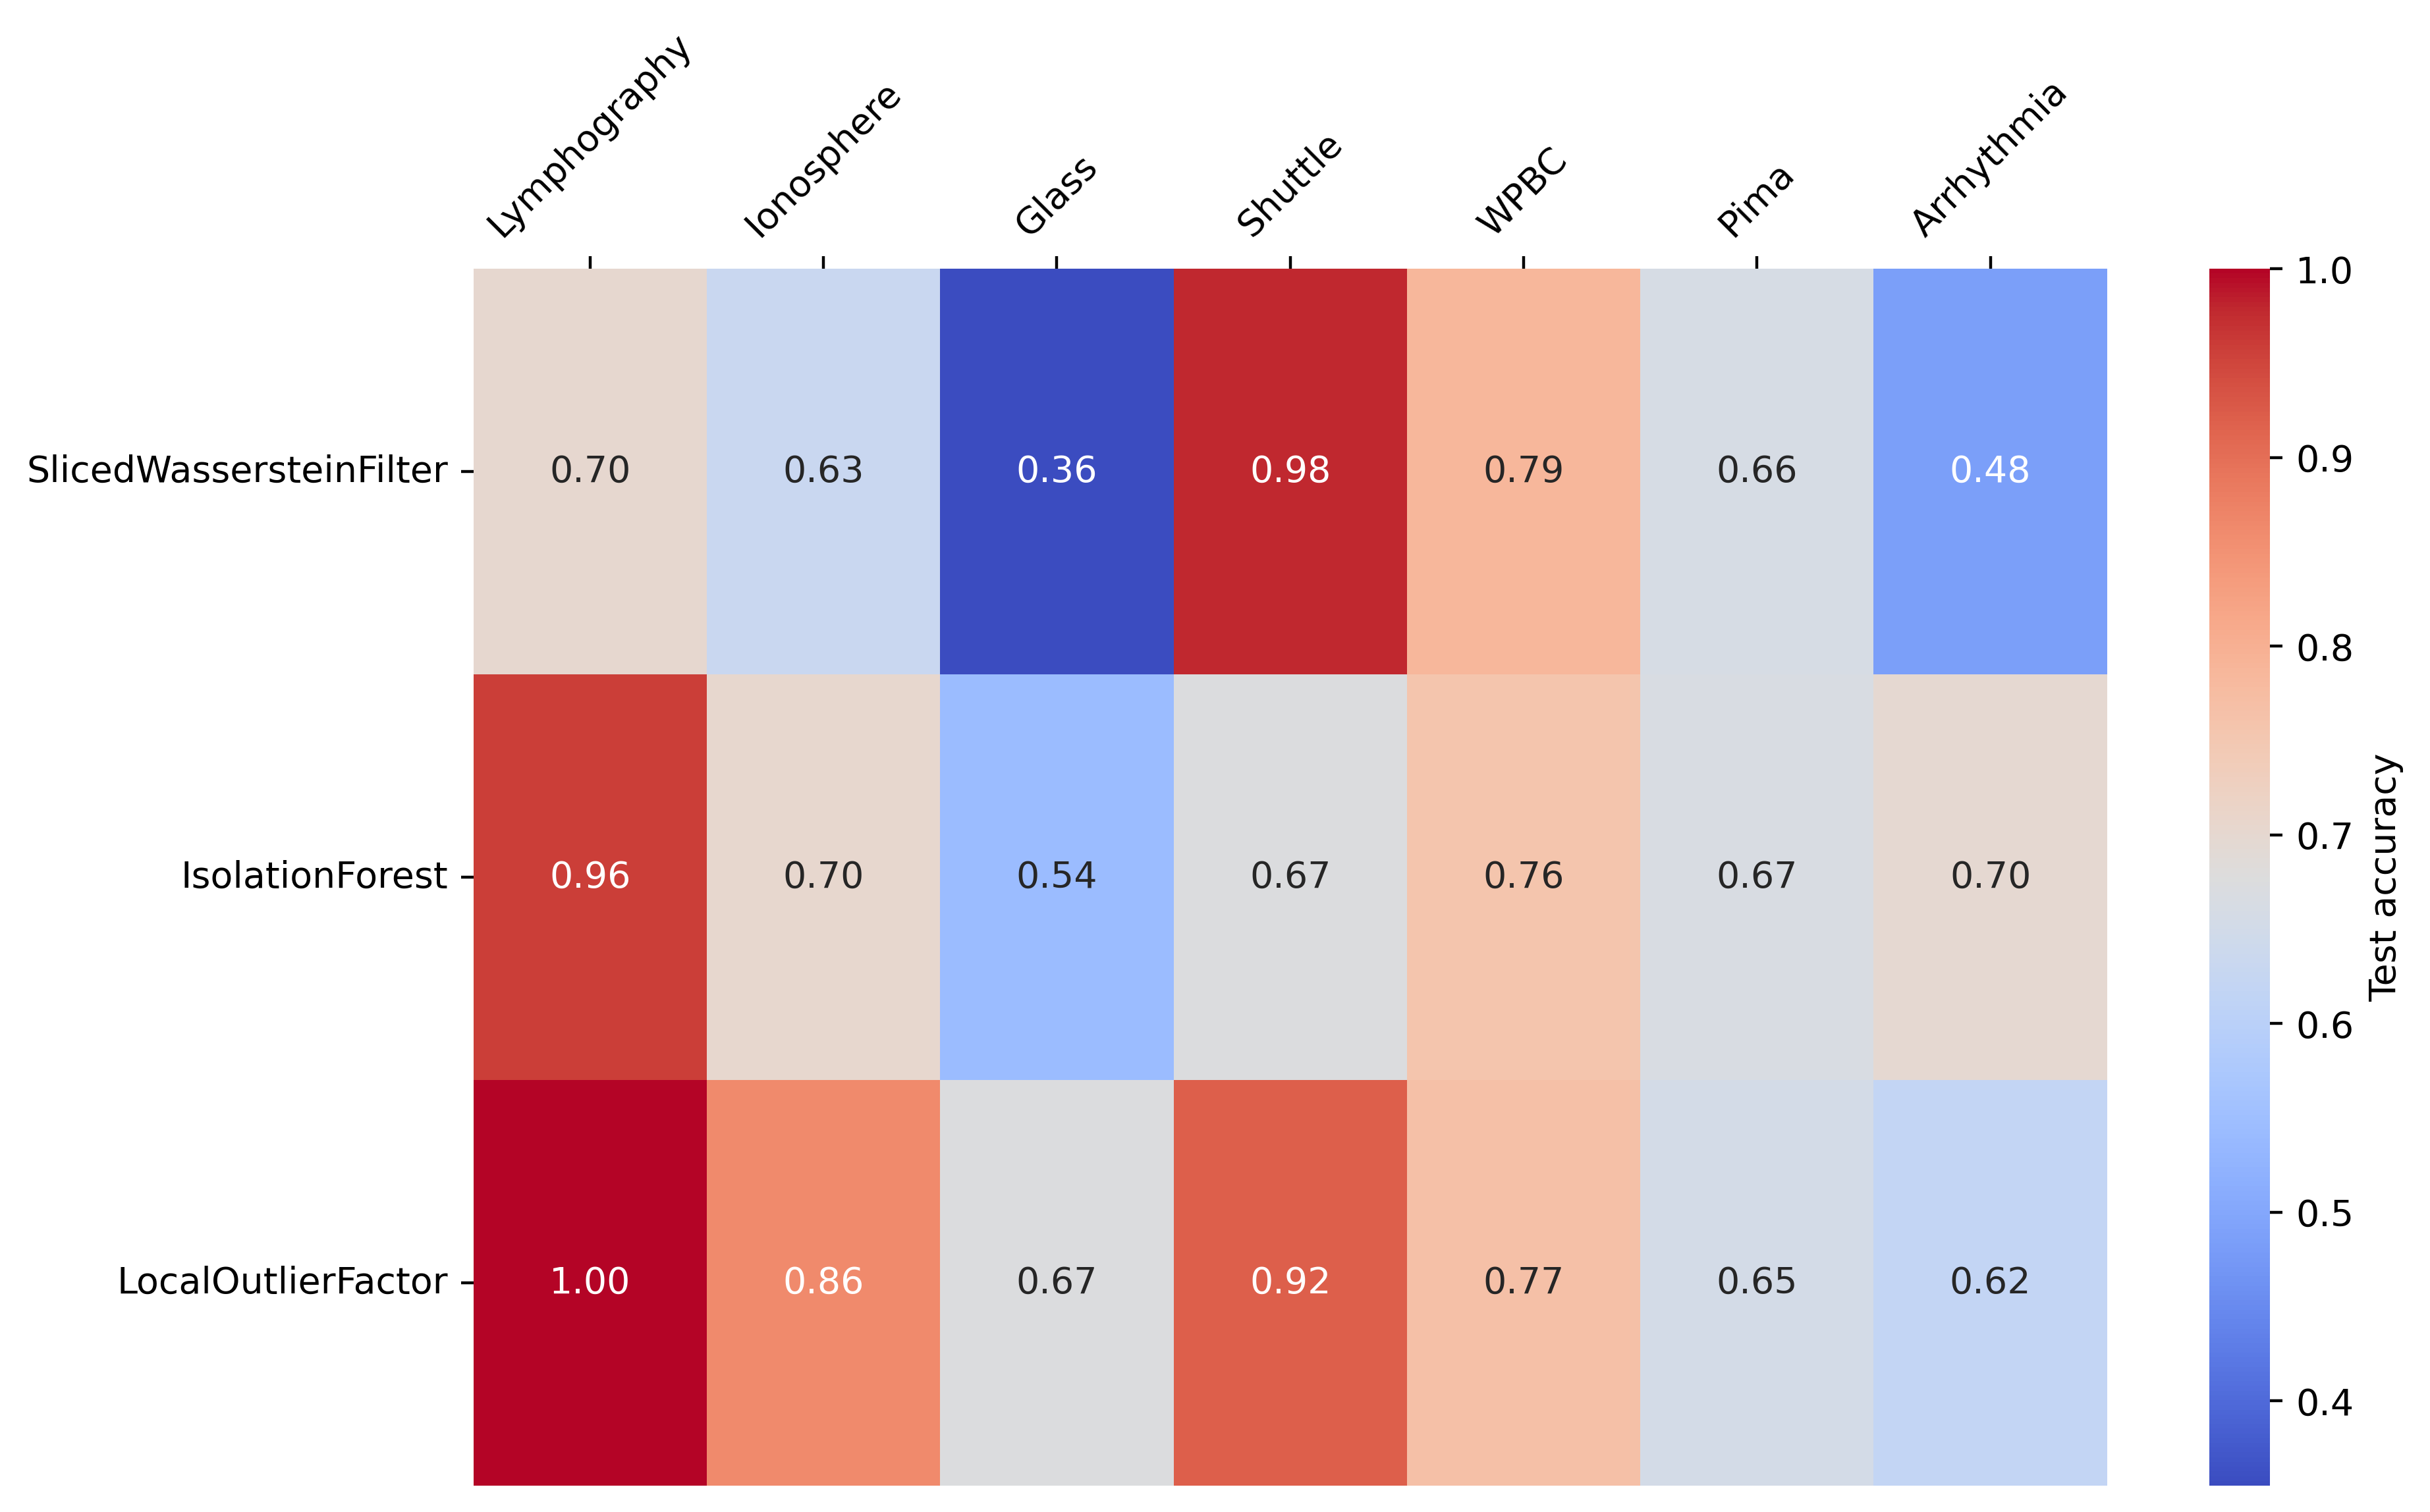

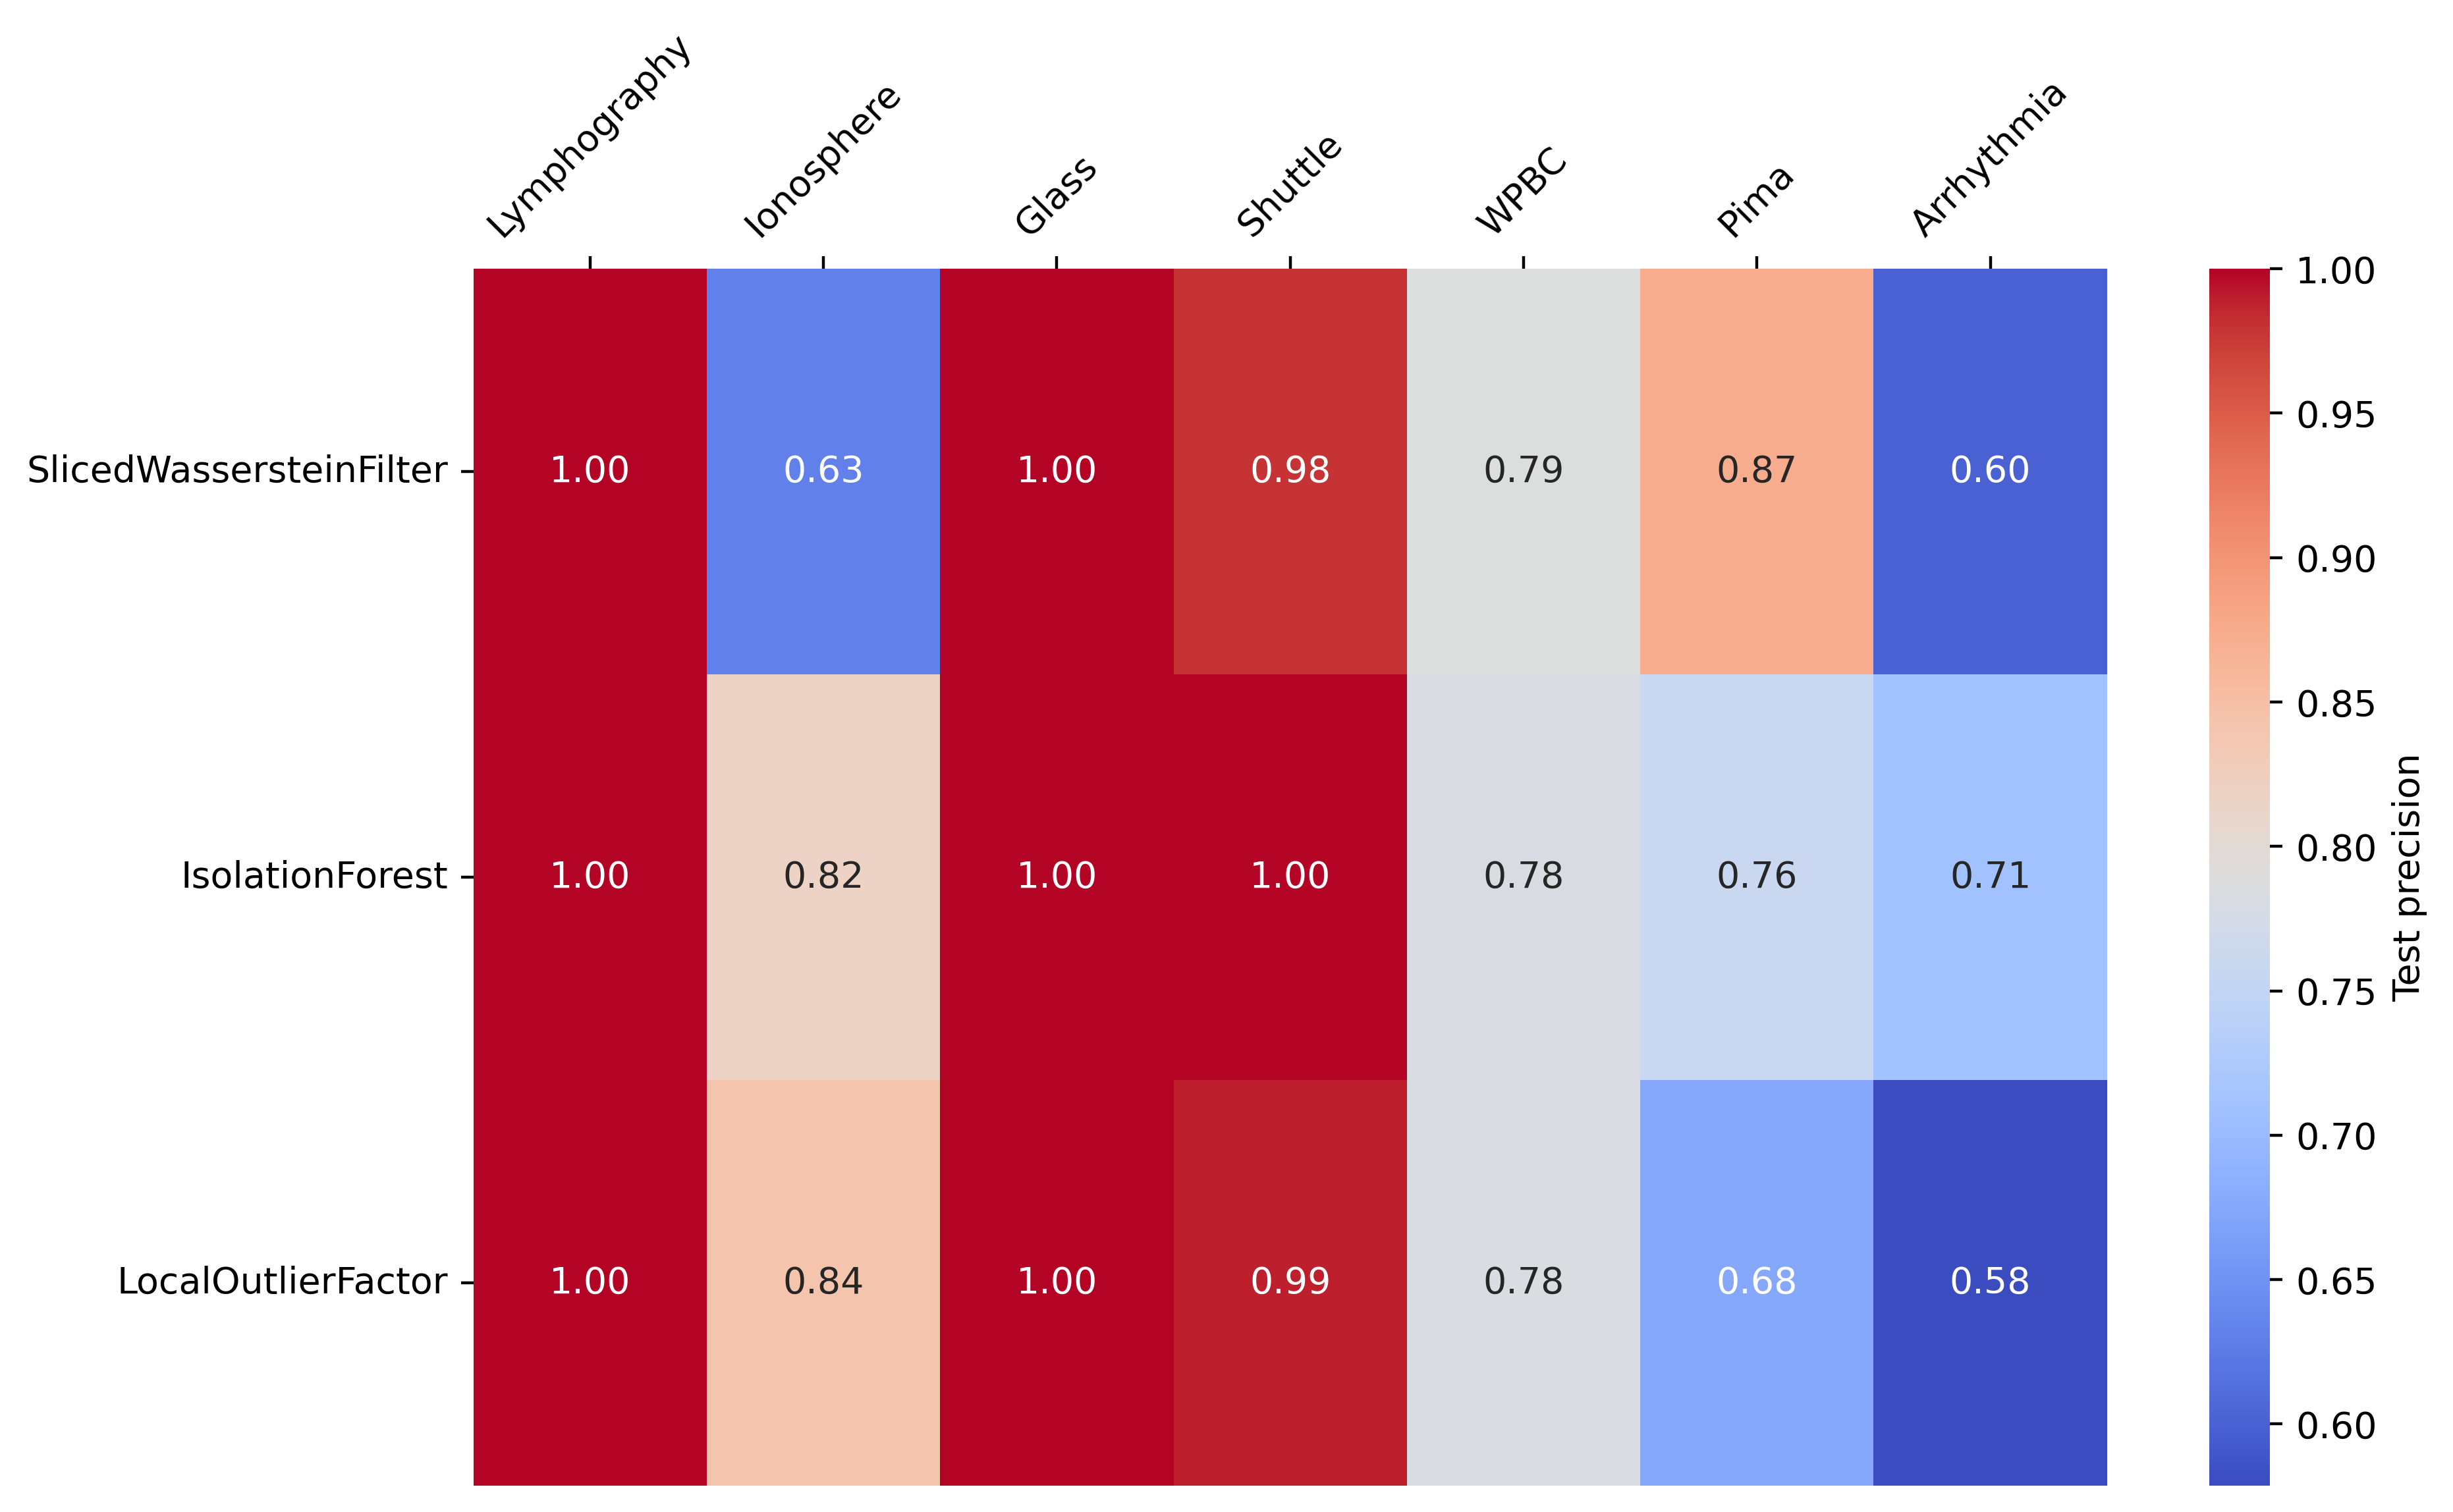

In [23]:
data = data_accuracy
# Normalize each column by its range
data_norm = (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(10, 6), dpi = 400)
#plt.tight_layout()
cmap = sns.color_palette("coolwarm", as_cmap=True)
heatmap = sns.heatmap(data.astype(float), cmap=cmap, annot=True, fmt=".2f",cbar_kws={'label': 'Test accuracy'})

# Set the function names as the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Set the function names as the x-axis labels and place them on top
heatmap.set_xticklabels(data.columns, rotation=45)
heatmap.xaxis.tick_top()

#plt.title('Your caption here', y=-0.1)
#plt.title('Normalized error metrics for different models and benchmark functions')
#plt.savefig('heatmap_JOPT.pdf', bbox_inches='tight')
plt.show()

data = data_precision
data_norm = (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(10, 6), dpi = 400)
#plt.tight_layout()
cmap = sns.color_palette("coolwarm", as_cmap=True)
heatmap = sns.heatmap(data.astype(float), cmap=cmap, annot=True, fmt=".2f",cbar_kws={'label': 'Test precision'})

# Set the function names as the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Set the function names as the x-axis labels and place them on top
heatmap.set_xticklabels(data.columns, rotation=45)
heatmap.xaxis.tick_top()

#plt.title('Your caption here', y=-0.1)
#plt.title('Normalized error metrics for different models and benchmark functions')
#plt.savefig('heatmap_JOPT.pdf', bbox_inches='tight')
plt.show()
